In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle


import pandas as pd
import copy

from sklearn.metrics import roc_curve , roc_auc_score , precision_recall_curve, confusion_matrix , f1_score
from collections import Counter

pd.options.display.max_rows = 200

# Import Models and Test Data

In [3]:
rf = pickle.load(open('rf_final.p','rb'))
gb = pickle.load(open('gb_final.p','rb'))
logit= pickle.load(open('logRegModel.p','rb'))
vote_soft = pickle.load(open('voting_classifer_soft.p','rb'))

In [4]:
X_val = pickle.load(open('X_val_processed.p','rb'))
y_val = pickle.load(open('y_val.p','rb'))
X_test = pickle.load(open('X_test_processed.p','rb'))
y_test = pickle.load(open('y_test.p','rb'))


In [87]:
cat_names = pickle.load(open('cat_columns.p','rb'))

# Build a ROC curve

In [6]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_val,rf.predict_proba(X_val)[:,1])
gb_fpr, gb_tpr, gb_thresholds = roc_curve(y_val,gb.predict_proba(X_val)[:,1])
logit_fpr, logit_tpr, logit_thresholds = roc_curve(y_val,logit.predict_proba(X_val)[:,1])
vote_soft_fpr, vote_soft_tpr, vote_soft_thresholds = roc_curve(y_val,vote_soft.predict_proba(X_val)[:,1])



roc_auc_rf = roc_auc_score(y_val,rf.predict_proba(X_val)[:,1])
roc_auc_gb = roc_auc_score(y_val,gb.predict_proba(X_val)[:,1])
roc_auc_logistic = roc_auc_score(y_val,logit.predict_proba(X_val)[:,1])
roc_auc_vote_soft = roc_auc_score(y_val,vote_soft.predict_proba(X_val)[:,1])



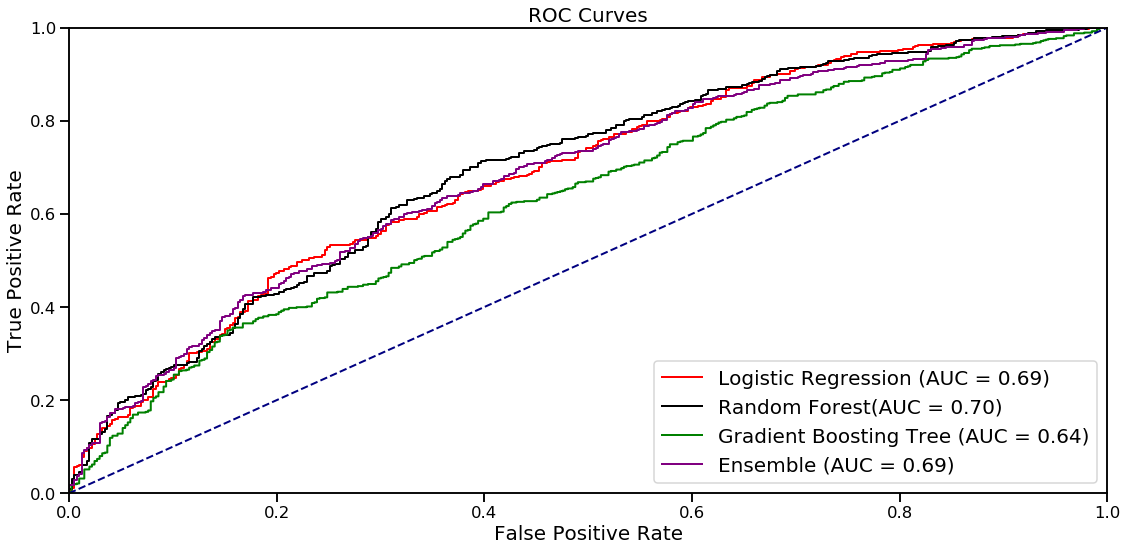

In [157]:
sns.set_context("talk")
fig = plt.figure(figsize=(16,8))



plt.plot(logit_fpr, logit_tpr, color='red',
         lw=lw, label='Logistic Regression (AUC = %0.2f)' % roc_auc_logistic)
plt.plot(rf_fpr, rf_tpr, color='black',
         lw=lw, label='Random Forest(AUC = %0.2f)' % roc_auc_rf)
plt.plot(gb_fpr, gb_tpr, color='green',
         lw=lw, label='Gradient Boosting Tree (AUC = %0.2f)' % roc_auc_gb)
plt.plot(vote_soft_fpr,vote_soft_tpr, color='purple',
         lw=lw, label='Ensemble (AUC = %0.2f)' % roc_auc_vote_soft)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate',fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('ROC Curves', fontsize = 20)
plt.legend(loc="lower right", fontsize = 20)
plt.tight_layout()
plt.savefig('roc_curves_all_ALL.png')
plt.savefig('roc_curves_svg_all_all.svg')
plt.show()

# Build a PR curve

In [8]:
rf_percision, rf_recall, rf_thresholds = precision_recall_curve(y_val,rf.predict_proba(X_val)[:,1])
gb_percision, gb_recall, gb_thresholds = precision_recall_curve(y_val,gb.predict_proba(X_val)[:,1])
logit_percision, logit_recall, logit_thresholds = precision_recall_curve(y_val,logit.predict_proba(X_val)[:,1])
vote_soft_percision, vote_soft_recall, vote_soft_thresholds = precision_recall_curve(y_val,vote_soft.predict_proba(X_val)[:,1])




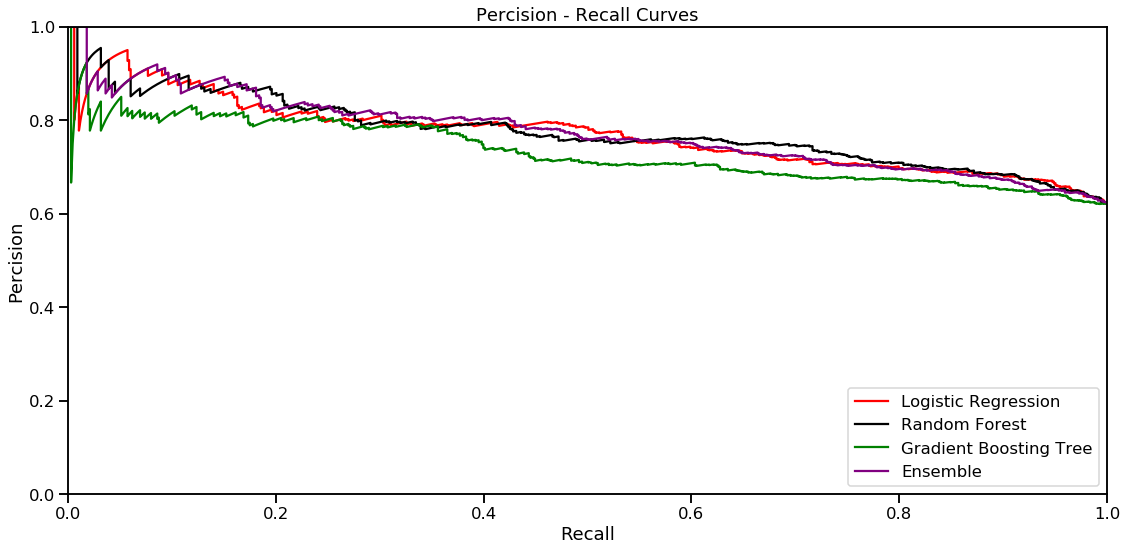

In [155]:
sns.set_context('talk')
fig = plt.figure(figsize=(16,8))



plt.plot( logit_recall,logit_percision, color='red',
          label='Logistic Regression')
plt.plot( rf_recall,rf_percision, color='black',
          label='Random Forest')
plt.plot( gb_recall,gb_percision, color='green',
          label='Gradient Boosting Tree')
plt.plot( vote_soft_recall,vote_soft_percision, color='purple',
          label='Ensemble')




plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Percision')
plt.title('Percision - Recall Curves')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig('PR_curves_all_ALL.png')
plt.savefig('PR_curves_svg_all_all.svg')
plt.show()

# Threshold Tuning 

In [10]:
threshold_tuner = pd.DataFrame({
    'y_val':y_val,
    'rf_prob':rf.predict_proba(X_val)[:,1],
    'gb_prob':gb.predict_proba(X_val)[:,1],
    'logit_prob':logit.predict_proba(X_val)[:,1],
    'ensemble_prob':vote_soft.predict_proba(X_val)[:,1]
})

In [11]:
threshold_tuner['threshold'] = 0 
threshold_tuner_exploded = pd.DataFrame(columns = threshold_tuner.columns)


for n in range(101):
    threshold_tuner['threshold'] = n/100
    threshold_tuner_exploded=threshold_tuner_exploded.append(threshold_tuner,ignore_index=True)

In [12]:

threshold_tuner_exploded['rf_fp'] = 0
threshold_tuner_exploded['rf_fn'] = 0



threshold_tuner_exploded['gb_fp'] = 0
threshold_tuner_exploded['gb_fn'] = 0



threshold_tuner_exploded['logit_fp'] = 0
threshold_tuner_exploded['logit_fn'] = 0



threshold_tuner_exploded['ensemble_fp'] = 0
threshold_tuner_exploded['ensemble_fn'] = 0


In [14]:
tte=copy.deepcopy(threshold_tuner_exploded)

In [15]:
tte.loc[(tte.rf_prob>tte.threshold) & tte.y_val==0, 'rf_fp'] = int(1)
tte.loc[(tte.gb_prob>tte.threshold) & tte.y_val==0, 'gb_fp'] = int(1)
tte.loc[(tte.logit_prob>tte.threshold) & tte.y_val==0, 'logit_fp'] = int(1)
tte.loc[(tte.ensemble_prob>tte.threshold) & tte.y_val==0, 'ensemble_fp'] = int(1)

tte.loc[(tte.rf_prob<tte.threshold) & tte.y_val==1, 'rf_fn'] = int(1)
tte.loc[(tte.gb_prob<tte.threshold) & tte.y_val==1, 'gb_fn'] = int(1)
tte.loc[(tte.logit_prob<tte.threshold) & tte.y_val==1, 'logit_fn'] = int(1)
tte.loc[(tte.ensemble_prob<tte.threshold) & tte.y_val==1, 'ensemble_fn'] = int(1)

In [16]:
tte.head()

,y_val,rf_prob,gb_prob,logit_prob,ensemble_prob,threshold,rf_fp,rf_fn,gb_fp,gb_fn,logit_fp,logit_fn,ensemble_fp,ensemble_fn
0,1,0.612254,0.910298,0.728733,0.577336,0.0,0,0,0,0,0,0,0,0
1,1,0.677646,0.365279,0.787282,0.772959,0.0,0,0,0,0,0,0,0,0
2,1,0.641392,0.987998,0.777093,0.816667,0.0,0,0,0,0,0,0,0,0
3,0,0.542042,0.008091,0.305853,0.349071,0.0,1,0,1,0,1,0,1,0
4,1,0.640004,0.478954,0.469313,0.670478,0.0,0,0,0,0,0,0,0,0


In [17]:
tte['rf_cost'] = tte['rf_fp'] * 150000 + tte['rf_fn']*8000
tte['gb_cost'] = tte['gb_fp'] * 150000 + tte['gb_fn']*8000
tte['ensemble_cost'] = tte['ensemble_fp'] * 15000 + tte['ensemble_fn']*8000
tte['logit_cost'] = tte['logit_fp'] * 150000 + tte['logit_fn']*8000

In [18]:
tte.groupby(by= 'threshold').sum().sort_values(by= 'gb_cost', ascending = True)

,rf_prob,gb_prob,logit_prob,ensemble_prob,rf_fp,rf_fn,gb_fp,gb_fn,logit_fp,logit_fn,ensemble_fp,ensemble_fn,rf_cost,gb_cost,ensemble_cost,logit_cost
threshold,,,,,,,,,,,,,,,,
0.00,660.333253,711.825544,666.72282,690.509921,406,0,406,0,406,0,406,0,60900000,60900000,6090000,60900000
0.01,660.333253,711.825544,666.72282,690.509921,406,0,442,36,406,0,406,0,60900000,66588000,6090000,60900000
0.02,660.333253,711.825544,666.72282,690.509921,406,0,454,48,406,0,406,0,60900000,68484000,6090000,60900000
0.03,660.333253,711.825544,666.72282,690.509921,406,0,464,58,406,0,406,0,60900000,70064000,6090000,60900000
0.04,660.333253,711.825544,666.72282,690.509921,406,0,473,67,406,0,406,0,60900000,71486000,6090000,60900000
0.05,660.333253,711.825544,666.72282,690.509921,406,0,480,74,406,0,406,0,60900000,72592000,6090000,60900000
0.06,660.333253,711.825544,666.72282,690.509921,406,0,483,77,406,0,406,0,60900000,73066000,6090000,60900000
0.07,660.333253,711.825544,666.72282,690.509921,406,0,488,82,406,0,406,0,60900000,73856000,6090000,60900000
0.08,660.333253,711.825544,666.72282,690.509921,406,0,492,86,406,0,406,0,60900000,74488000,6090000,60900000


In [19]:
tte.groupby(by= 'threshold').sum().sort_values(by= 'ensemble_cost', ascending = True)

,rf_prob,gb_prob,logit_prob,ensemble_prob,rf_fp,rf_fn,gb_fp,gb_fn,logit_fp,logit_fn,ensemble_fp,ensemble_fn,rf_cost,gb_cost,ensemble_cost,logit_cost
threshold,,,,,,,,,,,,,,,,
0.00,660.333253,711.825544,666.72282,690.509921,406,0,406,0,406,0,406,0,60900000,60900000,6090000,60900000
0.20,660.333253,711.825544,666.72282,690.509921,406,0,521,115,409,3,406,0,60900000,79070000,6090000,61374000
0.19,660.333253,711.825544,666.72282,690.509921,406,0,520,114,409,3,406,0,60900000,78912000,6090000,61374000
0.18,660.333253,711.825544,666.72282,690.509921,406,0,515,109,408,2,406,0,60900000,78122000,6090000,61216000
0.17,660.333253,711.825544,666.72282,690.509921,406,0,514,108,408,2,406,0,60900000,77964000,6090000,61216000
0.16,660.333253,711.825544,666.72282,690.509921,406,0,513,107,408,2,406,0,60900000,77806000,6090000,61216000
0.15,660.333253,711.825544,666.72282,690.509921,406,0,512,106,408,2,406,0,60900000,77648000,6090000,61216000
0.14,660.333253,711.825544,666.72282,690.509921,406,0,511,105,408,2,406,0,60900000,77490000,6090000,61216000
0.13,660.333253,711.825544,666.72282,690.509921,406,0,506,100,407,1,406,0,60900000,76700000,6090000,61058000


In [20]:
f1_score(y_test,rf.predict(X_test))

0.77354900095147483

In [21]:
df_test1 = pd.DataFrame({'feauture':X_test.columns, 'importance':rf.feature_importances_}).sort_values(by= 'importance',ascending=False)

In [22]:
df_test2 = df_test1[df_test1.importance != 0]

In [23]:
df_test2.sort_values(by='importance',ascending = False)

,feauture,importance
16763,LearningCategoryWork,1.963550e-02
16762,LearningCategoryOnlineCourses,1.396046e-02
16773,CompensationAmount,1.373884e-02
16760,Age,1.338151e-02
16767,TimeGatheringData,1.287630e-02
16768,TimeModelBuilding,1.276084e-02
16761,LearningCategorySelftTaught,1.125084e-02
16770,TimeVisualizing,1.002376e-02
16769,TimeProduction,9.556935e-03
16771,TimeFindingInsights,9.446334e-03


In [24]:
df_test2.shape

(2265, 2)

In [160]:
df_logReg1 = pd.DataFrame({'feauture':X_test.columns, 'coef':list(logit.coef_[0])}).sort_values(by= 'coef',ascending=False)

In [188]:
df_logReg1['odds'] = np.exp(df_logReg1.coef)
df_logReg1['abs_coef'] = abs(df_logReg1.coef)
df_logReg1.sort_values(by='abs_coef', ascending = False)

,feauture,coef,odds,abs_coef
22,x1_India,-0.440282,0.643855,0.440282
16746,x43_Never,-0.387490,0.678758,0.387490
16754,x44_Has stayed about the same (has not increas...,-0.375573,0.686895,0.375573
38,x1_People 's Republic of China,-0.372177,0.689232,0.372177
16752,x44_Has increased 20% or more,0.371292,1.449607,0.371292
80,x5_Poorly,-0.357326,0.699544,0.357326
5762,x22_Decreased significantly,-0.348768,0.705557,0.348768
5764,x22_Increased significantly,0.339432,1.404150,0.339432
87,x6_Employed by a company that performs advance...,0.332366,1.394263,0.332366
16758,x44_Other,0.327042,1.386860,0.327042


In [201]:
cat_names[18]

'MLTechniquesSelect'

In [25]:
f1_score(y_val,rf.predict(X_val))

0.77658303464755085

In [26]:
def predict_proba_output(X_val_proba, new_threshold):
    empty = []
    for values in X_val_proba[:,0]:
        if values <= new_threshold:
            empty.append(0)
        if values > new_threshold:
            empty.append(1)
    return(empty)

In [41]:
f1_score(y_val,predict_proba_output(rf.predict_proba(X_val),.25))

0.75741710296684128

In [29]:
Counter(vote_soft.predict(X_val))

Counter({1: 797, 0: 272})

In [36]:
count[1]

1056

In [37]:
count[2]

0

In [38]:
count

Counter({1: 1056, 0: 13})

In [30]:
int('6')

6

In [48]:
list(X_test.columns)

['x0_A different identity',
 'x0_Female',
 'x0_Male',
 'x0_Non-binary, genderqueer, or gender non-conforming',
 'x0_nan',
 'x1_Argentina',
 'x1_Australia',
 'x1_Belarus',
 'x1_Belgium',
 'x1_Brazil',
 'x1_Canada',
 'x1_Chile',
 'x1_Colombia',
 'x1_Czech Republic',
 'x1_Denmark',
 'x1_Egypt',
 'x1_Finland',
 'x1_France',
 'x1_Germany',
 'x1_Greece',
 'x1_Hong Kong',
 'x1_Hungary',
 'x1_India',
 'x1_Indonesia',
 'x1_Iran',
 'x1_Ireland',
 'x1_Israel',
 'x1_Italy',
 'x1_Japan',
 'x1_Kenya',
 'x1_Malaysia',
 'x1_Mexico',
 'x1_Netherlands',
 'x1_New Zealand',
 'x1_Nigeria',
 'x1_Norway',
 'x1_Other',
 'x1_Pakistan',
 "x1_People 's Republic of China",
 'x1_Philippines',
 'x1_Poland',
 'x1_Portugal',
 'x1_Republic of China',
 'x1_Romania',
 'x1_Russia',
 'x1_Singapore',
 'x1_South Africa',
 'x1_South Korea',
 'x1_Spain',
 'x1_Sweden',
 'x1_Switzerland',
 'x1_Taiwan',
 'x1_Turkey',
 'x1_Ukraine',
 'x1_United Kingdom',
 'x1_United States',
 'x1_Vietnam',
 'x1_nan',
 'x2_Employed full-time',
 'x

In [51]:
Counter(vote_soft.predict(X_val))[1]

797

In [56]:
Counter(vote_soft.predict(X_val))[0]

272

In [53]:
Counter(vote_soft.predict(X_val))

Counter({1: 797, 0: 272})

In [108]:
def predict_proba_output(X_val_proba, new_threshold):
    empty = []
    for values in X_val_proba[:,0]:
        if values <= new_threshold:
            empty.append(0)
        if values > new_threshold:
            empty.append(1)
    return(empty)

In [145]:
logit_preds = predict_proba_output(vote_soft.predict_proba(X_test), .20)

In [146]:
list(rf.predict_proba(X_test)[:,1])

[0.69443752307667761,
 0.60587633829109899,
 0.51080905926649234,
 0.67984853864568795,
 0.63804741360745798,
 0.64562426337866208,
 0.68709385973529225,
 0.58070405765080246,
 0.57794324663058416,
 0.60623175439872656,
 0.58361832183471629,
 0.64411762547541407,
 0.63729692161254992,
 0.45907515078708638,
 0.54403717758683201,
 0.69764991227980133,
 0.48622037567567078,
 0.66969656940793731,
 0.72166579984031032,
 0.68795320063755161,
 0.6426136075675406,
 0.60891755335124487,
 0.57468147678565884,
 0.56187606578678062,
 0.636820950073967,
 0.58885573056770268,
 0.63839448105030672,
 0.68137436038522636,
 0.49615400469595766,
 0.5932685044118795,
 0.67894052944504746,
 0.62707079335530724,
 0.55945031404181023,
 0.51298536806333439,
 0.58600988196221726,
 0.67315173708105258,
 0.59041850592802525,
 0.62284070494713883,
 0.67494904735819783,
 0.65357205664601448,
 0.68578074038059555,
 0.74330669117078252,
 0.61410752343121422,
 0.64075575009491981,
 0.67558561573609055,
 0.52500443034

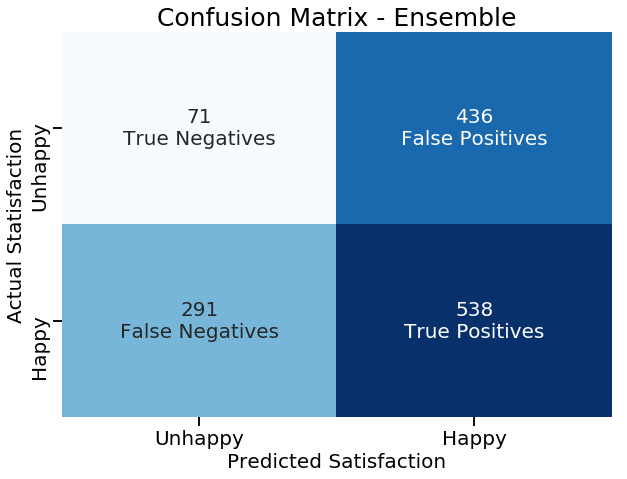

In [185]:
cm = confusion_matrix(y_test,logit_preds)
plt.figure(figsize=(25,7))
plt.subplot(131)
ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False,
               annot_kws={"size": 20}, fmt='g')
cmlabels = ['True Negatives', 'False Positives',
             'False Negatives', 'True Positives']
for i,t in enumerate(ax.texts):
   t.set_text(t.get_text() + "\n" + cmlabels[i])
plt.title('Confusion Matrix - Ensemble', size=25)
plt.xlabel('Predicted Satisfaction', size=20)
plt.ylabel('Actual Statisfaction', size=20)
labels = ['Unhappy', 'Happy']
ax.set_xticklabels(labels, size = 20)
ax.set_yticklabels(labels, size = 20)
plt.tight_layout()
plt.savefig('Confusion_matrix_ensemble.png')
plt.savefig('Confusion_matrix_ensemble.svg')
plt.show()

In [214]:
 confusion_matrix(y_test,logit_preds)[0][1]

436

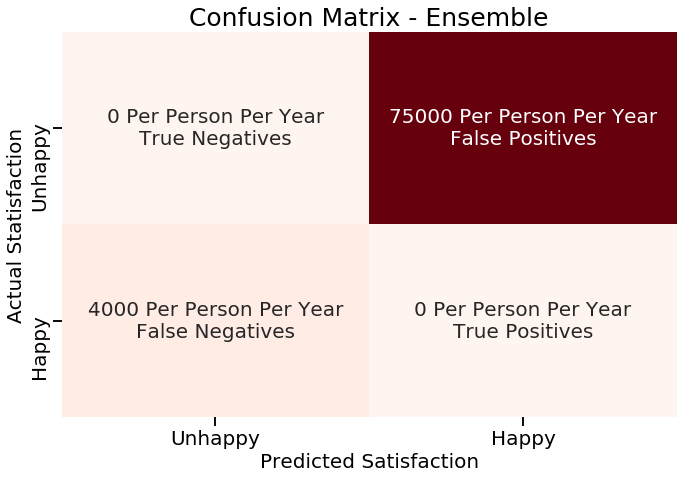

In [186]:
cm = ([[ 0, 75000],
       [4000, 0]])
plt.figure(figsize=(28,7))
plt.subplot(131)
ax = sns.heatmap(cm, annot=True, cmap='Reds', cbar=False,
               annot_kws={"size": 20}, fmt='g')
cmlabels = ['True Negatives', 'False Positives',
             'False Negatives', 'True Positives']
for i,t in enumerate(ax.texts):
   t.set_text(t.get_text() +' Per Person Per Year' + "\n" + cmlabels[i])
plt.title('Confusion Matrix - Ensemble', size=25)
plt.xlabel('Predicted Satisfaction', size=20)
plt.ylabel('Actual Statisfaction', size=20)
labels = ['Unhappy', 'Happy']
ax.set_xticklabels(labels, size = 20)
ax.set_yticklabels(labels, size = 20)
plt.tight_layout()
plt.savefig('Confusion_matrix_Cost.png')
plt.savefig('Confusion_matrix_cost.svg')
plt.show()